## 0. Setting up Environment

### 0.1 Libraries

In [151]:
import pandas as pd
import numpy as np
import re
from tabulate import tabulate

### 0.2 Functions

In [153]:
# Prints small readable dataframes
def pprint_df(dframe):
    print(tabulate(dframe, headers='keys', tablefmt='psql', showindex=False))

# Standardizes strings for columns names
def scrub_colnames(string):
    return re.sub(r'[($)]', '', string.lower().replace(' ', '_')).rstrip("_")

## 1. Reading in Data

### 1.1 Reading Raw Data

In [156]:
dat_raw = pd.read_csv('Medicalpremium.csv')

### 1.2 Standardize Column Names

In [158]:
outcols = ['BloodPressureProblems',
           'AnyTransplants',
           'AnyChronicDiseases',
           'KnownAllergies',
           'HistoryOfCancerInFamily',
           'NumberOfMajorSurgeries',
           'PremiumPrice']

incols = ['Blood_Pressure_Problems',
          'Any_Transplants',
          'Any_Chronic_Diseases',
          'Known_Allergies',
          'History_Of_Cancer_In_Family',
          'Number_Of_Major_Surgeries',
          'Premium_Price']

# Replace all columns labels of outcols with incols
dat = dat_raw
for incol, outcol in zip(incols, outcols):
    dat[incol] = dat[outcol]
    dat = dat.drop(outcol, axis=1)
    
dat.columns = dat.columns.map(scrub_colnames)

## 3. Predictive Modelling

### 3.1 AutoML using Lazy Predict (No Hyper parameter tuning, No Feature Selection, No Cross Validation)

In [161]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# Separate features and target
X = dat.drop(columns=['premium_price'])  # predictors
y = dat['premium_price']  # regression target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and run LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Show the results
print(models)


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 10
[LightGBM] [Info] Start training from score 24269.035533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### 3.3 Top Models as per AutoML

In [163]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Define adjusted R² function
def adjusted_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Define RMSE scorer for CV
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

results = {}

# Model grid with basic parameter search space
model_grid = {
    'GradientBoosting': (
        GradientBoostingRegressor(random_state=42),
        {'model__n_estimators': [100, 200], 'model__learning_rate': [0.1, 0.05]}
    ),
    'LGBM': (
        LGBMRegressor(random_state=42),
        {'model__n_estimators': [100, 200], 'model__learning_rate': [0.1, 0.05]}
    ),
    'CatBoost': (
        CatBoostRegressor(verbose=0, random_state=42),
        {'model__depth': [4, 6], 'model__learning_rate': [0.1, 0.05]}
    ),
    'HistGradientBoosting': (
        HistGradientBoostingRegressor(random_state=42),
        {'model__max_iter': [100, 200], 'model__learning_rate': [0.1, 0.05]}
    ),
    'RandomForest': (
        RandomForestRegressor(random_state=42),
        {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10]}
    )
}

# Loop through all models
for name, (model, param_grid) in model_grid.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=5)),
        ('model', model)
    ])

    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    n = X_test.shape[0]
    k = X_test.shape[1]

    # Hold-out test metrics
    mse = mean_squared_error(y_test, y_pred)#, squared=False)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2_score(r2, n, k)

    # Cross-validation scores
    cv_r2_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
    cv_r2 = np.mean(cv_r2_scores)
    cv_adj_r2 = adjusted_r2_score(cv_r2, X_train.shape[0], k)

    cv_rmse_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=rmse_scorer)
    cv_rmse = -np.mean(cv_rmse_scores)

    results[name] = {
        'Best Params': grid.best_params_,
        'RMSE': rmse,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'CV RMSE': cv_rmse,
        'CV R²': cv_r2,
        'CV Adjusted R²': cv_adj_r2
    }

# Display results in tabular format
results_df = pd.DataFrame(results).T
results_df = results_df[['RMSE', 'R²', 'Adjusted R²', 'CV RMSE', 'CV R²', 'CV Adjusted R²', 'Best Params']]
print("\nModel Performance Comparison with Feature Selection & Tuning:")
print(results_df.round(3))


Training GradientBoosting...
Training LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 5
[LightGBM] [Info] Start training from score 24269.035533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [164]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results).T  # Transpose for model names as rows
results_df = results_df.reset_index().rename(columns={'index': 'Model'})

# Round numeric columns for display
numeric_cols = ['RMSE', 'R²', 'Adjusted R²', 'CV R²', 'CV Adjusted R²']
results_df[numeric_cols] = results_df[numeric_cols].round(3)

# Display the table
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))



Model Performance Summary:
               Model                                                Best Params    RMSE   R² Adjusted R² CV RMSE CV R² CV Adjusted R²
    GradientBoosting {'model__learning_rate': 0.05, 'model__n_estimators': 100} 2832.32 0.81        0.80 3427.15  0.69           0.68
                LGBM {'model__learning_rate': 0.05, 'model__n_estimators': 100} 2784.71 0.82        0.81 3555.40  0.66           0.66
            CatBoost          {'model__depth': 4, 'model__learning_rate': 0.05} 2891.82 0.80        0.79 3714.07  0.63           0.63
HistGradientBoosting     {'model__learning_rate': 0.05, 'model__max_iter': 100} 2784.72 0.82        0.81 3556.03  0.66           0.66
        RandomForest       {'model__max_depth': 10, 'model__n_estimators': 100} 3003.53 0.79        0.78 3804.69  0.61           0.61


### 3.5 Best Model

asets.


### Why We Selected `HistGradientBoostingRegressor` as the Champion Model

- It achieved the **third-lowest Cross-Validated RMSE**, indicating strong predictive performance, only slightly behind the top two models.
- It also secured the **third-highest Cross-Validated Adjusted R²**, demonstrating a good balance between accuracy and model complexity.
- We preferred it over `GradientBoostingRegressor` because:
  - `HistGradientBoostingRegressor` is **faster and more efficient**, especially on large datasets, which is important for this use case.
- We selected it over `LGBMRegressor` because:
  - `LGBMRegressor` can be **more prone to overfitting**


### 3.6 Tradeoffs Made while selecting the Best Model

### Summary Tradeoff Table:

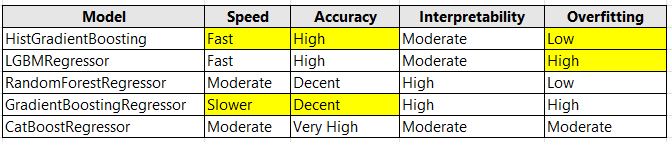


### SHAP Analysis Commentary – Insurance Premium Prediction - HistGradientBoosting

This SHAP summary plot explains the impact of each feature on insurance premium predictions:

#### 1. `age`
- Higher `age` values (pink dots on far right side of vertical 0 line) significantly increase predicted premiums.
- Lower `age` values (blue dots on the far left side of vertical 0 line) decrease premiums.
- Clear positive correlation: **older individuals → higher insurance costs**.

#### 2. `any_transplants`
- Having undergone a transplant leads to a strong increase in predicted premiums (pink dots on far right).
- Those without (blue values - low feature value were not on extremes) have minimal or even negative influence on premiums.

#### 3. `any_chronic_diseases`
- Individuals with chronic conditions (pink dots on right side of vertical 0 line) show increase in premiums.
- Those without (blue values - low feature value were not on extremes) have minimal or even negative influence on premiums.

#### 4. `number_of_major_surgeries`
- More major surgeries tend to increase premiums slightly, but the effect is less consistent since low (blue) and high values (pink) overlap around 0

#### 5. `blood_pressure_problems`
- Least influential among the top 5 features.
- High blood pressure (small pink - High Value dots on little right of vertical 0 lines) contributes marginally to higher premiums. The blue and pink dots overlapping around 0 indicate little to no effect on prediction 



### 3.8 Scatter Plot of actual Vs predicted premium

## 4. Dashboard

### 4.1

In [186]:
import streamlit as st
import altair as alt
import plotly.express as px

#best_model.get_params()
tmodels = models.T
#models

In [188]:
def make_heatmap(input_df, input_y, input_x, input_color, input_color_theme):
    heatmap = alt.Chart(input_df).mark_rect().encode(
        y=alt.Y(f'{input_y}:O', axis=alt.Axis(title="", titleFontSize=18, titlePadding=15, titleFontWeight=900, labelAngle=0)),
        x=alt.X(f'{input_x}:O', axis=alt.Axis(title="", titleFontSize=18, titlePadding=15, titleFontWeight=900)),
        color=alt.Color(f'max({input_color}):Q',
                        legend=None,
                        scale=alt.Scale(scheme=input_color_theme)),
        stroke=alt.value('black'),
        strokeWidth=alt.value(0.25),
        ).properties(width=900
                     ).configure_axis(
        labelFontSize=12,
        titleFontSize=12
        ) 
    # height=300
    return heatmap

st.set_page_config(
    page_title="US Population Dashboard",
    page_icon="🏂",
    layout="wide",
    initial_sidebar_state="expanded")

alt.themes.enable("dark")

with st.sidebar:
    st.title('🏂 US Population Dashboard')
    
    model_list = list(models.RMSE.unique())[::-1]
    
    selected_model = st.selectbox('Select a model', model_list, index=len(model_list)-1)
    df_selected_model = models[models.RMSE == selected_model]
    df_selected_model_sorted = df_selected_model.sort_values(by="Time Taken", ascending=False)

    color_theme_list = ['blues', 'cividis', 'greens', 'inferno', 'magma', 'plasma', 'reds', 'rainbow', 'turbo', 'viridis']
    selected_color_theme = st.selectbox('Select a color theme', color_theme_list)

col = st.columns((5), gap='medium')

with col[0]:
    st.markdown('#### Top States')

    st.dataframe(df_selected_model_sorted,
                 column_order=("RMSE", "Time Taken"),
                 hide_index=True,
                 width=None,
                 column_config={
                    "RMSE": st.column_config.TextColumn(
                        "RMSE",
                    ),
                    "Time Taken": st.column_config.ProgressColumn(
                        "Time Taken",
                        format="%f",
                        min_value=0,
                        max_value=max(df_selected_model_sorted.xs('Time Taken', axis=1)),
                     )}
                 )
    
    with st.expander('About', expanded=True):
        st.write('''
            - Data: [U.S. Census Bureau](<https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html>).
            - :orange[**Gains/Losses**]: states with high inbound/ outbound migration for selected year
            - :orange[**States Migration**]: percentage of states with annual inbound/ outbound migration > 50,000
            ''')

2025-04-26 13:16:31.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 13:16:31.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 13:16:31.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 13:16:31.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 13:16:31.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 13:16:31.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 13:16:31.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 13:16:31.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar